# Imports

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import sys
sys.path.append("/ocean/projects/asc170022p/singla/Explanation_XRay/")
import yaml
from utils import *
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
import scipy.misc as scm
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
np.random.seed(0)

In [4]:
main_dir = '/ocean/projects/asc170022p/singla/Explanation_XRay'

# Get MIMIC dataset

In [5]:
df_file_name = '/ocean/projects/asc170022p/singla/Datasets/MIMIC-CXR/PA_AP_views_image_report_labels.csv'

In [6]:
df_mimic = pd.read_csv(df_file_name)
df_mimic = df_mimic.fillna(0)
print(df_mimic.shape)

(215518, 23)


In [7]:
df_mimic.head(1)

,original_index,Reports,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Lesion,Lung Opacity,Edema,Consolidation,Pneumonia,...,Pleural Other,Fracture,Support Devices,study_id,subject_id,lateral_512_jpeg,report,ViewPosition,StudyDate,dicom_id
0,0,No acute cardiopulmonary abnormality.,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,s53189527,p10000032,/ocean/projects/asc170022p/shared/Data/chestXR...,/ocean/projects/asc170022p/shared/Data/chestXR...,PA,0.0,0.0


In [8]:
df_mimic['lateral_512_jpeg'][0]

'/ocean/projects/asc170022p/shared/Data/chestXRayDatasets/MIMICCXR/2.0.0/files/p10/p10000032/s53189527/view3_lateral_HE_512.jpeg'

# Read config

In [12]:
config = os.path.join(main_dir, 'configs/StanfordCheXpert_Classifier_256_ICLR.yaml')
config = yaml.load(open(config))
for k in config.keys():
    print(k, config[k])

('output_folder_name', 'To_Delete_MIMIC')
('partition', 'train')
('image_dir', '/ocean/projects/asc170022p/shared/Data/chestXRayDatasets/StanfordCheXpert')
('output_csv', '/ocean/projects/asc170022p/singla/Datasets/MIMIC-CXR/PA_AP_views_image_report_labels.csv')
('do_center_crop', True)
('batch_size', 200)
('num_channel', 1)
('epochs', 5)
('seed', 0)
('classifier_type', 'DenseNet')
('training_columns_to_repeat', '')
('path_column', 'Path')
('categories', 'Lung Lesion,Pleural Effusion,Edema,Cardiomegaly,Consolidation,Support Devices,No Finding,Pneumonia,Fracture,Atelectasis,Pneumothorax,Enlarged Cardiomediastinum,Lung Opacity,Pleural Other')
('num_class', 14)
('name', 'StanfordCheXpert_256_ICLR')
('ckpt_dir_continue', 'output/classifier/StanfordCheXpert_256_ICLR')
('use_output_csv', True)
('output_csv_names_column', 'lateral_512_jpeg')
('feature', False)
('only_frontal', 1)
('train', '/ocean/projects/asc170022p/shared/Data/chestXRayDatasets/StanfordCheXpert/CheXpert-v1.0-small/train.csv

In [13]:
categories = config['categories']
categories = categories.split(',')
categories

['Lung Lesion',
 'Pleural Effusion',
 'Edema',
 'Cardiomegaly',
 'Consolidation',
 'Support Devices',
 'No Finding',
 'Pneumonia',
 'Fracture',
 'Atelectasis',
 'Pneumothorax',
 'Enlarged Cardiomediastinum',
 'Lung Opacity',
 'Pleural Other']

In [15]:
output_dir = os.path.join(main_dir,config['log_dir'], config['name'], config['output_folder_name'])
print(output_dir)

/ocean/projects/asc170022p/singla/Explanation_XRay/output/classifier/StanfordCheXpert_256_ICLR/To_Delete_MIMIC


# Load saved output from classifier

In [16]:
# Read classifier output
train_or_test = 'train'
names = np.load(os.path.join(output_dir, 'name_train.npy'),allow_pickle=True)
prediction_y = np.load(os.path.join(output_dir, 'prediction_y_train.npy'))
true_y = np.load(os.path.join(output_dir, 'true_y_train.npy'))
print(names.shape, prediction_y.shape, true_y.shape)

((200200,), (200200, 14), (200200, 14))


In [17]:
true_y[true_y==-1]=1

## Create a dataframe

In [18]:
df_output = pd.DataFrame()
df_output['names'] = names
for i in range(len(categories)):
    df_output[categories[i] + '_label'] = true_y[:,i]
    df_output[categories[i] + '_prob'] = prediction_y[:,i]
print(df_output.shape)
df_output.head(2)

(200200, 29)


,names,Lung Lesion_label,Lung Lesion_prob,Pleural Effusion_label,Pleural Effusion_prob,Edema_label,Edema_prob,Cardiomegaly_label,Cardiomegaly_prob,Consolidation_label,...,Atelectasis_label,Atelectasis_prob,Pneumothorax_label,Pneumothorax_prob,Enlarged Cardiomediastinum_label,Enlarged Cardiomediastinum_prob,Lung Opacity_label,Lung Opacity_prob,Pleural Other_label,Pleural Other_prob
0,/ocean/projects/asc170022p/shared/Data/chestXR...,0.0,0.341385,0.0,0.228079,0.0,0.023932,0.0,0.050886,0.0,...,0.0,0.150798,0.0,0.023863,0.0,0.176438,0.0,0.338982,0.0,0.212671
1,/ocean/projects/asc170022p/shared/Data/chestXR...,0.0,0.427898,0.0,0.073220,0.0,0.067508,0.0,0.060497,0.0,...,0.0,0.170197,0.0,0.018150,0.0,0.086128,0.0,0.457597,0.0,0.030984


In [19]:
for c in categories:
    print(c)
    print(np.unique(df_output[c + '_label'], return_counts=True))

Lung Lesion
(array([0., 1.], dtype=float32), array([193146,   7054]))
Pleural Effusion
(array([0., 1.], dtype=float32), array([146772,  53428]))
Edema
(array([0., 1.], dtype=float32), array([164196,  36004]))
Cardiomegaly
(array([0., 1.], dtype=float32), array([158420,  41780]))
Consolidation
(array([0., 1.], dtype=float32), array([186986,  13214]))
Support Devices
(array([0., 1.], dtype=float32), array([140725,  59475]))
No Finding
(array([0., 1.], dtype=float32), array([132643,  67557]))
Pneumonia
(array([0., 1.], dtype=float32), array([169626,  30574]))
Fracture
(array([0., 1.], dtype=float32), array([195830,   4370]))
Atelectasis
(array([0., 1.], dtype=float32), array([150580,  49620]))
Pneumothorax
(array([0., 1.], dtype=float32), array([189914,  10286]))
Enlarged Cardiomediastinum
(array([0., 1.], dtype=float32), array([191024,   9176]))
Lung Opacity
(array([0., 1.], dtype=float32), array([151686,  48514]))
Pleural Other
(array([0., 1.], dtype=float32), array([197827,   2373]))


## View results from classifier

In [21]:
for i in [1,2,3]:
    print(categories[i], i)
    print("ROC-AUC: ", roc_auc_score(true_y[:,i], prediction_y[:,i]))
    print("Accuracy: ", accuracy_score(true_y[:,i], (prediction_y[:,i]>0.5).astype(int)))
    print("Recall: ", recall_score(true_y[:,i], (prediction_y[:,i]>0.5).astype(int)))
    tp = np.sum((prediction_y[true_y[:,i] == 1,i]>0.5).astype(int))
    print("Stats: ", np.unique(true_y[:,i], return_counts=True), tp)
    print(confusion_matrix(true_y[:,i],  (prediction_y[:,i]>0.5).astype(int)))

('Pleural Effusion', 1)
('ROC-AUC: ', 0.8681183984132523)
('Accuracy: ', 0.7836163836163836)
('Recall: ', 0.8115407651418731)
('Stats: ', (array([0., 1.], dtype=float32), array([146772,  53428])), 43359)
[[113521  33251]
 [ 10069  43359]]
('Edema', 2)
('ROC-AUC: ', 0.8438758504983555)
('Accuracy: ', 0.7781418581418581)
('Recall: ', 0.7349183424063993)
('Stats: ', (array([0., 1.], dtype=float32), array([164196,  36004])), 26460)
[[129324  34872]
 [  9544  26460]]
('Cardiomegaly', 3)
('ROC-AUC: ', 0.7519988255099771)
('Accuracy: ', 0.6427972027972028)
('Recall: ', 0.7607228338918143)
('Stats: ', (array([0., 1.], dtype=float32), array([158420,  41780])), 31783)
[[96905 61515]
 [ 9997 31783]]


# Merge the two datasets

In [23]:
df_merged = pd.merge(df_mimic,df_output,left_on='lateral_512_jpeg',right_on='names', how='right')
print(df_merged.shape)
df_merged = df_merged.fillna(0)
df_merged.head(2)

(200200, 52)


,original_index,Reports,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Lesion,Lung Opacity,Edema,Consolidation,Pneumonia,...,Atelectasis_label,Atelectasis_prob,Pneumothorax_label,Pneumothorax_prob,Enlarged Cardiomediastinum_label,Enlarged Cardiomediastinum_prob,Lung Opacity_label,Lung Opacity_prob,Pleural Other_label,Pleural Other_prob
0,0,No acute cardiopulmonary abnormality.,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.150798,0.0,0.023863,0.0,0.176438,0.0,0.338982,0.0,0.212671
1,1,No acute cardiopulmonary process.,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.170197,0.0,0.018150,0.0,0.086128,0.0,0.457597,0.0,0.030984


## Only pacemaker

In [137]:
df_pace_i = df_merged.loc[df_merged['pacemaker_y'] == 1]
df_pace_f = df_merged.loc[df_merged['pacemaker_x'] == 1]
df_pace_no_f = df_merged.loc[df_merged['pacemaker_x'] == 0]
df_pace_i.shape, df_pace_f.shape, df_pace_no_f.shape

((1496, 359), (5938, 359), (209286, 359))

In [139]:
all_pacemaker = np.asarray(df_pace_f['lateral'])
np.save(os.path.join(experiment_dir, 'all_pacemaker.npy'), all_pacemaker)

In [123]:
a = np.asarray(list(set(np.asarray(df_pace_f['lateral']))  - set(np.asarray(df_pace_i['lateral']))))  
print(a.shape)
a[0:2]

(4446,)


array(['/pghbio/dbmi/batmanlab/singla/Image_Text_Project/MIMICCX/Data/512/18667287/56239467/view3_lateral_HE.jpeg',
       '/pghbio/dbmi/batmanlab/singla/Image_Text_Project/MIMICCX/Data/512/11438173/50280956/view2_lateral_HE.jpeg'],
      dtype='|S105')

In [124]:
df_no_pace = df_pace_no_f.sample(n=2000)

In [125]:
df_no_pace.shape

(2000, 359)

In [126]:
name_no_pace= np.asarray(df_no_pace['names'])
print(name_no_pace.shape)
name_no_pace[0:2]

(2000,)


array(['/pghbio/dbmi/batmanlab/singla/Image_Text_Project/MIMICCX/Data/512/19034797/55258617/view2_lateral_HE.jpeg',
       '/pghbio/dbmi/batmanlab/singla/Image_Text_Project/MIMICCX/Data/512/14666079/56613804/view2_lateral_HE.jpeg'],
      dtype=object)

In [127]:
name_pace = np.asarray(df_pace_i['names'])
print(name_pace.shape)
name_pace[0:3]

(1496,)


array(['/pghbio/dbmi/batmanlab/singla/Image_Text_Project/MIMICCX/Data/512/10001884/50376803/view2_lateral_HE.jpeg',
       '/pghbio/dbmi/batmanlab/singla/Image_Text_Project/MIMICCX/Data/512/10013569/52553082/view2_lateral_HE.jpeg',
       '/pghbio/dbmi/batmanlab/singla/Image_Text_Project/MIMICCX/Data/512/10013643/52222477/view2_lateral_HE.jpeg'],
      dtype=object)

In [129]:
aa = np.random.choice(a,500)

In [131]:
print(aa.shape)
aa[0:3]

(500,)


array(['/pghbio/dbmi/batmanlab/singla/Image_Text_Project/MIMICCX/Data/512/16205152/57391484/view3_lateral_HE.jpeg',
       '/pghbio/dbmi/batmanlab/singla/Image_Text_Project/MIMICCX/Data/512/15211758/50893415/view3_lateral_HE.jpeg',
       '/pghbio/dbmi/batmanlab/singla/Image_Text_Project/MIMICCX/Data/512/19747096/56762751/view2_lateral_HE.jpeg'],
      dtype='|S105')

In [132]:
name_pace = np.append(name_pace, aa)
name_pace.shape

(1996,)

In [133]:
one = np.ones(name_pace.shape)
zero = np.zeros(name_no_pace.shape)
label_pace = np.append(one, zero)
name_all = np.append(name_pace, name_no_pace)
print(label_pace.shape, name_all.shape)
print(name_all[0:3])

((3996,), (3996,))
['/pghbio/dbmi/batmanlab/singla/Image_Text_Project/MIMICCX/Data/512/10001884/50376803/view2_lateral_HE.jpeg'
 '/pghbio/dbmi/batmanlab/singla/Image_Text_Project/MIMICCX/Data/512/10013569/52553082/view2_lateral_HE.jpeg'
 '/pghbio/dbmi/batmanlab/singla/Image_Text_Project/MIMICCX/Data/512/10013643/52222477/view2_lateral_HE.jpeg']


In [134]:
df_pace = pd.DataFrame()
df_pace['names'] = name_all
df_pace['label'] = label_pace
print(df_pace.shape)
df_pace.head(2)

(3996, 2)


,names,label
0,/pghbio/dbmi/batmanlab/singla/Image_Text_Proje...,1.0
1,/pghbio/dbmi/batmanlab/singla/Image_Text_Proje...,1.0


In [135]:
experiment_dir

'/pghbio/dbmi/batmanlab/singla/Explanation_XRay/output/classifier/StanfordCheXpert_256_ICLR/explainer_MIMIC'

In [136]:
df_temp = df_pace
df_temp.to_csv(os.path.join(experiment_dir, 'list_attr_pacemaker.txt'), sep = ' ', index = None, header = None)
print(df_temp.shape)
one_line = str(df_temp.shape[0]) + '\n'
second_line = "pacemaker\n"
with open(os.path.join(experiment_dir, 'list_attr_pacemaker.txt'), 'r+') as fp:
    lines = fp.readlines()     # lines is list of line, each element '...\n'
    lines.insert(0, one_line)  # you can use any index if you know the line index
    lines.insert(1, second_line)
    fp.seek(0)                 # file pointer locates at the beginning to write the whole file again
    fp.writelines(lines) 
fp = open(os.path.join(experiment_dir, 'list_attr_pacemaker.txt'), 'rw')
print(fp.readline())
print(fp.readline())
print(fp.readline())
print(fp.readline())
print(fp.readline())
print(fp.readline())
df_bin_all.to_csv(os.path.join(experiment_dir, 'extra','Data_Output_Classifier_'+'pacemaker'+'.csv'), sep = ' ', index = None)

(3996, 2)
3996

pacemaker

/pghbio/dbmi/batmanlab/singla/Image_Text_Project/MIMICCX/Data/512/10001884/50376803/view2_lateral_HE.jpeg 1.0

/pghbio/dbmi/batmanlab/singla/Image_Text_Project/MIMICCX/Data/512/10013569/52553082/view2_lateral_HE.jpeg 1.0

/pghbio/dbmi/batmanlab/singla/Image_Text_Project/MIMICCX/Data/512/10013643/52222477/view2_lateral_HE.jpeg 1.0

/pghbio/dbmi/batmanlab/singla/Image_Text_Project/MIMICCX/Data/512/10013643/52512677/view2_lateral_HE.jpeg 1.0



## Choose a traget class to build explanation

In [19]:
current_index = 3
name = categories[current_index]
print(name)
current_index_prob = current_index

Cardiomegaly


In [20]:
extra_keyword ='pacemaker_x'
print(np.unique(df_merged[extra_keyword], return_counts=True))
df_merged[extra_keyword] = df_merged[extra_keyword].apply(lambda x: 1 if x == -1 else x)
print(np.unique(df_merged[extra_keyword], return_counts=True))

(array([-1.,  0.,  1.]), array([   256, 209286,   5938]))
(array([0., 1.]), array([209286,   6194]))


## Create a dataframe from results

In [21]:
df_explain = df_merged[['names', name+'_prob',name+'_label_full', name+'_label_imp', extra_keyword]]
df_explain['bin'] = np.floor(df_explain[name+'_prob'].astype('float') * 10).astype('int')
df_explain['bin'] = (df_explain['bin']* 0.5).astype('int')
df_explain = df_explain.drop_duplicates()
print(df_explain.shape)
df_explain.head(3)

(215480, 6)


,names,Cardiomegaly_prob,Cardiomegaly_label_full,Cardiomegaly_label_imp,pacemaker_x,bin
0,/pghbio/dbmi/batmanlab/singla/Image_Text_Proje...,0.358708,0.0,0.0,0.0,1
1,/pghbio/dbmi/batmanlab/singla/Image_Text_Proje...,0.079592,0.0,0.0,0.0,0
2,/pghbio/dbmi/batmanlab/singla/Image_Text_Proje...,0.430650,0.0,0.0,0.0,2


## Plot reliability curve

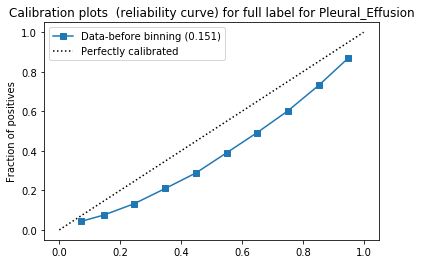

In [64]:
#Reliability Curve
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
true_label = np.asarray(df_explain[name+'_label_full']).astype(int)
predicted_prob = np.asarray(df_explain[name+'_prob']).astype(float)
fraction_of_positives, mean_predicted_value = calibration_curve(true_label, predicted_prob, n_bins=10)
clf_score = brier_score_loss(true_label, predicted_prob, pos_label=1)
plt.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % ('Data-before binning', clf_score))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.ylabel('Fraction of positives')
#plt.ylim([-0.05, 1.05])
plt.title('Calibration plots  (reliability curve) for full label for '+ name)
plt.legend()
plt.show()

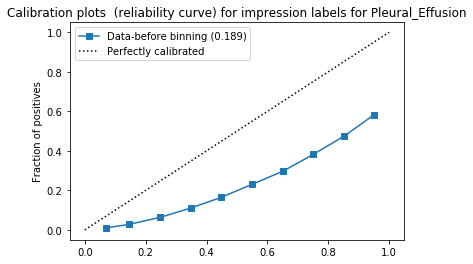

In [65]:
#Reliability Curve
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
true_label = np.asarray(df_explain[name+'_label_imp']).astype(int)
predicted_prob = np.asarray(df_explain[name+'_prob']).astype(float)
fraction_of_positives, mean_predicted_value = calibration_curve(true_label, predicted_prob, n_bins=10)
clf_score = brier_score_loss(true_label, predicted_prob, pos_label=1)
plt.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % ('Data-before binning', clf_score))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.ylabel('Fraction of positives')
#plt.ylim([-0.05, 1.05])
plt.title('Calibration plots  (reliability curve) for impression labels for '+ name)
plt.legend()
plt.show()

# Create bins

In [22]:
df_explain.head(1)

,names,Cardiomegaly_prob,Cardiomegaly_label_full,Cardiomegaly_label_imp,pacemaker_x,bin
0,/pghbio/dbmi/batmanlab/singla/Image_Text_Proje...,0.358708,0.0,0.0,0.0,1


In [23]:
df_explain.groupby(by='bin').count()

,names,Cardiomegaly_prob,Cardiomegaly_label_full,Cardiomegaly_label_imp,pacemaker_x
bin,,,,,
0,64858,64858,64858,64858,64858
1,43962,43962,43962,43962,43962
2,32174,32174,32174,32174,32174
3,30870,30870,30870,30870,30870
4,43616,43616,43616,43616,43616


In [29]:
df_explain.groupby(by=['bin', name+'_label_full',name+'_label_imp',extra_keyword]).count()

names  \
bin Cardiomegaly_label_full Cardiomegaly_label_imp pacemaker_x          
0   0.0                     0.0                    0.0          56632   
                                                   1.0            530   
                            1.0                    0.0              9   
    1.0                     0.0                    0.0           5035   
                                                   1.0             88   
                            1.0                    0.0           2516   
                                                   1.0             48   
1   0.0                     0.0                    0.0          31867   
                                                   1.0            477   
                            1.0                    0.0             12   
    1.0                     0.0                    0.0           7037   
                                                   1.0            218   
                            1.0                    0.0           4265   
                                                   1.0             86   
2   0.0                     0.0                    0.0          19486   
                                                   1.0            373   
                            1.0                    0.0              8   
    1.0                     0.0                    0.0           7077   
                                                   1.0            280   
                            1.0                    0.0           4816   
                                                   1.0            134   
3   0.0                     0.0                    0.0          14857   
                                                   1.0            421   
                            1.0                    0.0              6   
    1.0                     0.0                    0.0           8481   
                                                   1.0            474   
                            1.0                    0.0           6396   
                                                   1.0            235   
4   0.0                     0.0                    0.0          12583   
                                                   1.0            582   
                            1.0                    0.0              7   
    1.0                     0.0                    0.0          14225   
                                                   1.0           1323   
                            1.0                    0.0          13971   
                                                   1.0            925   

                                                                Cardiomegaly_prob  
bin Cardiomegaly_label_full Cardiomegaly_label_imp pacemaker_x                     
0   0.0                     0.0                    0.0                      56632  
                                                   1.0                        530  
                            1.0                    0.0                          9  
    1.0                     0.0                    0.0                       5035  
                                                   1.0                         88  
                            1.0                    0.0                       2516  
                                                   1.0                         48  
1   0.0                     0.0                    0.0                      31867  
                                                   1.0                        477  
                            1.0                    0.0                         12  
    1.0                     0.0                    0.0                       7037  
                                                   1.0                        218  
                            1.0                    0.0                       4265  
                                                   1.0                         86  
2   0.0           

## Custom sampling

In [69]:
n = 787*2

In [70]:
bin_0 = df_explain.loc[df_explain['bin'] == 0]
bin_0 = bin_0.loc[bin_0[name+'_label_imp'] == 0]
bin_0 = bin_0.loc[bin_0[name+'_label_full'] == 0]
bin_0 = bin_0.loc[bin_0[extra_keyword] == 0]
bin_0_final = bin_0.sample(n = n, random_state=0)
print(bin_0_final.shape)
bin_0_final.groupby(by=[extra_keyword, name+'_label_full',name+'_label_imp']).count()

(1574, 6)


,,,names,Cardiomegaly_prob,bin
pacemaker_x,Cardiomegaly_label_full,Cardiomegaly_label_imp,,,
0.0,0.0,0.0,1574,1574,1574


In [71]:
bin_1 = df_explain.loc[df_explain['bin'] == 1]
bin_1 = bin_1.loc[bin_1[name+'_label_imp'] == 0]
bin_1 = bin_1.loc[bin_1[name+'_label_full'] == 0]
bin_1 = bin_1.loc[bin_1[extra_keyword] == 0]
bin_1_final = bin_1.sample(n = n, random_state=0)
print(bin_1_final.shape)
bin_1_final.groupby(by=[extra_keyword, name+'_label_full',name+'_label_imp']).count()

(1574, 6)


,,,names,Cardiomegaly_prob,bin
pacemaker_x,Cardiomegaly_label_full,Cardiomegaly_label_imp,,,
0.0,0.0,0.0,1574,1574,1574


In [72]:
bin_2 = df_explain.loc[df_explain['bin'] == 2]
bin_2_0 = bin_2.loc[bin_2[name+'_label_imp'] == 0]
bin_2_0 = bin_2_0.loc[bin_2_0[name+'_label_full'] == 0]
bin_2_0 = bin_2_0.loc[bin_2_0[extra_keyword] == 0]
bin_2_0 = bin_2_0.sample(n = int(n/2), random_state=0)
bin_2_1 = bin_2.loc[bin_2[extra_keyword] == 1]
bin_2_final = pd.concat([bin_2_0, bin_2_1])  
print(bin_2_0.shape, bin_2_1.shape,bin_2_final.shape)
bin_2_final.groupby(by=[extra_keyword, name+'_label_full',name+'_label_imp']).count()

((787, 6), (787, 6), (1574, 6))


names  \
pacemaker_x Cardiomegaly_label_full Cardiomegaly_label_imp          
0.0         0.0                     0.0                       787   
1.0         0.0                     0.0                       373   
            1.0                     0.0                       280   
                                    1.0                       134   

                                                            Cardiomegaly_prob  \
pacemaker_x Cardiomegaly_label_full Cardiomegaly_label_imp                      
0.0         0.0                     0.0                                   787   
1.0         0.0                     0.0                                   373   
            1.0                     0.0                                   280   
                                    1.0                                   134   

                                                            bin  
pacemaker_x Cardiomegaly_label_full Cardiomegaly_label_imp       
0.0         0.0                     0.0                     787  
1.0         0.0                     0.0                     373  
            1.0                     0.0                     280  
                                    1.0                     134

In [73]:
bin_3 = df_explain.loc[df_explain['bin'] == 3]
bin_3_1 = bin_3.loc[bin_3[extra_keyword] == 1]
print(bin_3_1.shape)
bin_3_1.groupby(by=[extra_keyword, name+'_label_full',name+'_label_imp']).count()

(1130, 6)


names  \
pacemaker_x Cardiomegaly_label_full Cardiomegaly_label_imp          
1.0         0.0                     0.0                       421   
            1.0                     0.0                       474   
                                    1.0                       235   

                                                            Cardiomegaly_prob  \
pacemaker_x Cardiomegaly_label_full Cardiomegaly_label_imp                      
1.0         0.0                     0.0                                   421   
            1.0                     0.0                                   474   
                                    1.0                                   235   

                                                            bin  
pacemaker_x Cardiomegaly_label_full Cardiomegaly_label_imp       
1.0         0.0                     0.0                     421  
            1.0                     0.0                     474  
                                    1.0                     235

In [74]:
bin_4 = df_explain.loc[df_explain['bin'] == 4]
bin_4_1 = bin_4.loc[bin_4[extra_keyword] == 1]
bin_4_1_1 = bin_4_1.loc[bin_4_1[name+'_label_imp'] == 1]
print(bin_4_1_1.shape)
bin_4_0 = bin_4_1.loc[bin_4_1[name+'_label_full'] == 1]
bin_4_0 = bin_4_0.loc[bin_4_0[name+'_label_imp'] == 0]
print(bin_4_0.shape)
bin_4_0 = bin_4_0.sample(n=n-bin_4_1_1.shape[0], random_state=0)
bin_4_final = pd.concat([bin_4_1_1, bin_4_0])  
print(bin_4_final.shape)
bin_4_final.groupby(by=[extra_keyword, name+'_label_full',name+'_label_imp']).count()

(925, 6)
(1323, 6)
(1574, 6)


names  \
pacemaker_x Cardiomegaly_label_full Cardiomegaly_label_imp          
1.0         1.0                     0.0                       649   
                                    1.0                       925   

                                                            Cardiomegaly_prob  \
pacemaker_x Cardiomegaly_label_full Cardiomegaly_label_imp                      
1.0         1.0                     0.0                                   649   
                                    1.0                                   925   

                                                            bin  
pacemaker_x Cardiomegaly_label_full Cardiomegaly_label_imp       
1.0         1.0                     0.0                     649  
                                    1.0                     925

In [75]:
df_bin_all = pd.concat([bin_0_final, bin_1_final, bin_2_final, bin_3_1, bin_4_final])   

In [76]:
print(np.unique(df_bin_all['bin'] ,return_counts=True))

(array([0, 1, 2, 3, 4]), array([1574, 1574, 1574, 1130, 1574]))


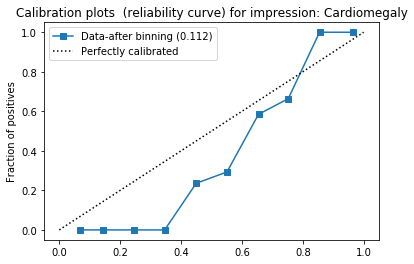

In [81]:
#Reliability Curve
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
true_label = np.asarray(df_bin_all[name+'_label_full']).astype(int)
predicted_prob = np.asarray(df_bin_all[name+'_prob']).astype(float)
fraction_of_positives, mean_predicted_value = calibration_curve(true_label, predicted_prob, n_bins=10)
clf_score = brier_score_loss(true_label, predicted_prob, pos_label=1)
plt.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % ('Data-after binning', clf_score))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.ylabel('Fraction of positives')
plt.ylim([-0.05, 1.05])
plt.title('Calibration plots  (reliability curve) for impression: '+name)
plt.legend()
plt.show()

In [82]:
experiment_dir = os.path.join(main_dir,config['log_dir'], config['name'], 'explainer_MIMIC')
print(experiment_dir,name)
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

('/pghbio/dbmi/batmanlab/singla/Explanation_XRay/output/classifier/StanfordCheXpert_256_ICLR/explainer_MIMIC', 'Cardiomegaly')


In [83]:
name1 = name + '_' + extra_keyword

In [84]:
df_temp = df_bin_all[['names', 'bin']]
df_temp.to_csv(os.path.join(experiment_dir, 'list_attr_'+name1+'.txt'), sep = ' ', index = None, header = None)
print(df_temp.shape)
one_line = str(df_temp.shape[0]) + '\n'
second_line = "0-0.19 0.2-0.39 0.4-0.59 0.6-0.79 0.8-0.99\n"
with open(os.path.join(experiment_dir, 'list_attr_'+name1+'.txt'), 'r+') as fp:
    lines = fp.readlines()     # lines is list of line, each element '...\n'
    lines.insert(0, one_line)  # you can use any index if you know the line index
    lines.insert(1, second_line)
    fp.seek(0)                 # file pointer locates at the beginning to write the whole file again
    fp.writelines(lines) 
fp = open(os.path.join(experiment_dir, 'list_attr_'+name1+'.txt'), 'rw')
print(fp.readline())
print(fp.readline())
print(fp.readline())
print(fp.readline())
print(fp.readline())
print(fp.readline())
df_bin_all.to_csv(os.path.join(experiment_dir, 'extra','Data_Output_Classifier_'+name1+'.csv'), sep = ' ', index = None)

(7426, 2)
7426

0-0.19 0.2-0.39 0.4-0.59 0.6-0.79 0.8-0.99

/pghbio/dbmi/batmanlab/singla/Image_Text_Project/MIMICCX/Data/512/13852361/51445877/view3_lateral_HE.jpeg 0

/pghbio/dbmi/batmanlab/singla/Image_Text_Project/MIMICCX/Data/512/19078733/58509574/view3_lateral_HE.jpeg 0

/pghbio/dbmi/batmanlab/singla/Image_Text_Project/MIMICCX/Data/512/17070596/51505898/view3_lateral_HE.jpeg 0

/pghbio/dbmi/batmanlab/singla/Image_Text_Project/MIMICCX/Data/512/18750684/53712364/view2_lateral_HE.jpeg 0



## Caliberated Sampling

In [28]:
for i in range(5):
    print i
    df_bin = df.loc[df['bin'] == i]
    print(df_bin.shape)
    print(np.min(df_bin['prob']), np.max(df_bin['prob']))
    print(np.unique(df_bin['label'],return_counts=True))
    df_bin_0 = df.loc[(df['bin'] == i) & (df['label'] ==0)]
    df_bin_1 = df.loc[(df['bin'] == i) & (df['label'] ==1)]
    n_0 = int((1 - (0.1 * i) ) * n)
    if df_bin_0.shape[0] >= n_0:
        df_bin = df_bin_0.sample(n=n_0)
    else:
        df_bin = df_bin_0
        n_0 = df_bin_0.shape[0]
    n_1 = n - n_0
    if df_bin_1.shape[0] >= n_1:
        df_bin = pd.concat([df_bin, df_bin_1.sample(n=n_1)])        
    else:
        df_bin = pd.concat([df_bin, df_bin_1])    
        
    if i == 0:
        df_bin_all = df_bin
    else:
        df_bin_all = pd.concat([df_bin, df_bin_all])
    print(df_bin_all.shape)
    print(np.unique(df_bin['label'],return_counts=True))

0
(106218, 4)
(3.6645753e-10, 0.09999554)
(array([0.0, 1.0], dtype=object), array([102029,   4189]))
(4000, 4)
(array([0.0], dtype=object), array([4000]))
1
(24214, 4)
(0.100000754, 0.19999897)
(array([0.0, 1.0], dtype=object), array([21187,  3027]))
(8000, 4)
(array([0.0, 1.0], dtype=object), array([3600,  400]))
2
(14218, 4)
(0.20001338, 0.29999754)
(array([0.0, 1.0], dtype=object), array([11645,  2573]))
(12000, 4)
(array([0.0, 1.0], dtype=object), array([3200,  800]))
3
(10191, 4)
(0.30001906, 0.3999659)
(array([0.0, 1.0], dtype=object), array([7699, 2492]))
(16000, 4)
(array([0.0, 1.0], dtype=object), array([2800, 1200]))
4
(8052, 4)
(0.40002975, 0.499973)
(array([0.0, 1.0], dtype=object), array([5700, 2352]))
(20000, 4)
(array([0.0, 1.0], dtype=object), array([2400, 1600]))
5
(6917, 4)
(0.5000184, 0.59997404)
(array([0.0, 1.0], dtype=object), array([4304, 2613]))
(24000, 4)
(array([0.0, 1.0], dtype=object), array([2000, 2000]))
6
(6123, 4)
(0.60001254, 0.6999439)
(array([0.0, 1.0

In [29]:
print(np.unique(df_bin_all['bin'] ,return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000]))


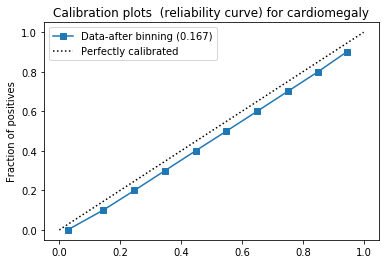

In [30]:
#Reliability Curve
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
true_label = np.asarray(df_bin_all['label']).astype(int)
predicted_prob = np.asarray(df_bin_all['prob']).astype(float)
fraction_of_positives, mean_predicted_value = calibration_curve(true_label, predicted_prob, n_bins=10)
clf_score = brier_score_loss(true_label, predicted_prob, pos_label=1)
plt.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % ('Data-after binning', clf_score))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.ylabel('Fraction of positives')
plt.ylim([-0.05, 1.05])
plt.title('Calibration plots  (reliability curve) for '+name)
plt.legend()
plt.show()

## Save the output

In [31]:
experiment_dir = os.path.join(main_dir+config['log_dir'][1:], config['name'], 'explainer_input')

In [32]:
print(experiment_dir,name)
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

('/pghbio/dbmi/batmanlab/singla/Explanation_XRay/output/classifier/StanfordCheXpert_128_ICLR/explainer_input', 'cardiomegaly')


In [34]:
name = 'cardiomegaly_caliberated'

In [35]:
df_temp = df_bin_all[['filename', 'bin']]
df_temp.to_csv(os.path.join(experiment_dir, 'list_attr_'+name+'.txt'), sep = ' ', index = None, header = None)
print(df_temp.shape)
one_line = str(df_temp.shape[0]) + '\n'
second_line = "0-0.09 0.1-0.19 0.2-0.29 0.3-0.39 0.4-0.49 0.5-0.59 0.6-0.69 0.7-0.79 0.8-0.89 0.9-0.99\n"
with open(os.path.join(experiment_dir, 'list_attr_'+name+'.txt'), 'r+') as fp:
    lines = fp.readlines()     # lines is list of line, each element '...\n'
    lines.insert(0, one_line)  # you can use any index if you know the line index
    lines.insert(1, second_line)
    fp.seek(0)                 # file pointer locates at the beginning to write the whole file again
    fp.writelines(lines) 
fp = open(os.path.join(experiment_dir, 'list_attr_'+name+'.txt'), 'rw')
print(fp.readline())
print(fp.readline())
print(fp.readline())
print(fp.readline())
print(fp.readline())
print(fp.readline())
df_bin_all.to_csv(os.path.join(experiment_dir, 'Data_Output_Classifier_'+name+'.csv'), sep = ' ', index = None)
df_test_results.to_csv(os.path.join(experiment_dir, 'Data_Output_Classifier_All_Test_'+name+'.csv'), sep = ' ', index = None)
df_train_results.to_csv(os.path.join(experiment_dir, 'Data_Output_Classifier_All_Train_'+name+'.csv'), sep = ' ', index = None)

(40000, 2)
40000

0-0.09 0.1-0.19 0.2-0.29 0.3-0.39 0.4-0.49 0.5-0.59 0.6-0.69 0.7-0.79 0.8-0.89 0.9-0.99

CheXpert-v1.0-small/train/patient39726/study6/view1_frontal.jpg 9

CheXpert-v1.0-small/train/patient01167/study6/view1_frontal.jpg 9

CheXpert-v1.0-small/train/patient02298/study3/view2_lateral.jpg 9

CheXpert-v1.0-small/train/patient15635/study8/view2_lateral.jpg 9



In [6]:
experiment_dir = '../StanfordCheXpert_256_ICLR/explainer/extra/'
name = 'Cardiomegaly'

In [7]:
df_combine = pd.read_csv(os.path.join(experiment_dir, 'Data_Output_Classifier_'+name+'.csv'), sep = ' ')

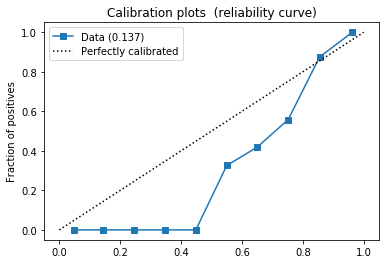

In [8]:
#Reliability Curve
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)

fraction_of_positives, mean_predicted_value = calibration_curve(df_combine['label'], df_combine["prob"], n_bins=10)
clf_score = brier_score_loss(df_combine['label'], df_combine["prob"], pos_label=1)
plt.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % ('Data', clf_score))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.ylabel('Fraction of positives')
plt.ylim([-0.05, 1.05])
plt.title('Calibration plots  (reliability curve)')
plt.legend()
plt.show()

# Un-caliberated sampling

In [68]:
n = 4000
df = df_explain
df.head()

,names,Pleural_Effusion_prob,Pleural_Effusion_label_full,Pleural_Effusion_label_imp,bin
0,/pghbio/dbmi/batmanlab/singla/Image_Text_Proje...,0.146888,0.0,0.0,1
1,/pghbio/dbmi/batmanlab/singla/Image_Text_Proje...,0.234968,0.0,0.0,2
2,/pghbio/dbmi/batmanlab/singla/Image_Text_Proje...,0.468043,0.0,0.0,4
3,/pghbio/dbmi/batmanlab/singla/Image_Text_Proje...,0.246989,0.0,0.0,2
4,/pghbio/dbmi/batmanlab/singla/Image_Text_Proje...,0.420101,0.0,0.0,4


In [69]:
name

'Pleural_Effusion'

In [70]:
label = '_label_imp'

In [71]:
np.random.seed(0)
for i in range(0,10):
    print i
    df_bin = df.loc[df['bin'] == i]
    print(df_bin.shape)
    print(np.min(df_bin[name+'_prob']), np.max(df_bin[name+'_prob']))
    print(np.unique(df_bin[name+label],return_counts=True))
    df_bin_0 = df.loc[(df['bin'] == i) & (df[name+label] ==0)]
    df_bin_1 = df.loc[(df['bin'] == i) & (df[name+label] ==1)]
    if i < 5:
        if df_bin_0.shape[0] >= n:
            df_bin = df_bin_0.sample(n=n)
        else:
            df_bin = df_bin_0
            n_0 = df_bin_0.shape[0]
            n_1 = n - n_0
            if df_bin_1.shape[0] >= n_1:
                df_bin = pd.concat([df_bin, df_bin_1.sample(n=n_1)]) 
    else:
        if df_bin_1.shape[0] >= n:
            df_bin = df_bin_1.sample(n=n)
        else:
            df_bin = df_bin_1
            n_0 = df_bin_1.shape[0]
            n_1 = n - n_0
            if df_bin_0.shape[0] >= n_1:
                df_bin = pd.concat([df_bin, df_bin_0.sample(n=n_1)]) 
            else:
                df_bin = pd.concat([df_bin, df_bin_0]) 
        
    if i == 0:
        df_bin_all = df_bin
    else:
        df_bin_all = pd.concat([df_bin, df_bin_all])
    print(df_bin_all.shape)
    print(np.unique(df_bin[name+label],return_counts=True))

0
(28434, 5)
(0.0068184077, 0.09999714)
(array([0., 1.]), array([28125,   309]))
(4000, 5)
(array([0.]), array([4000]))
1
(43132, 5)
(0.10000053, 0.19999513)
(array([0., 1.]), array([41931,  1201]))
(8000, 5)
(array([0.]), array([4000]))
2
(25637, 5)
(0.20000881, 0.299998)
(array([0., 1.]), array([24020,  1617]))
(12000, 5)
(array([0.]), array([4000]))
3
(18357, 5)
(0.3000019, 0.3999765)
(array([0., 1.]), array([16328,  2029]))
(16000, 5)
(array([0.]), array([4000]))
4
(15420, 5)
(0.4000052, 0.4999889)
(array([0., 1.]), array([12873,  2547]))
(20000, 5)
(array([0.]), array([4000]))
5
(14325, 5)
(0.50000966, 0.5999653)
(array([0., 1.]), array([11019,  3306]))
(24000, 5)
(array([0., 1.]), array([ 694, 3306]))
6
(13806, 5)
(0.60000867, 0.6999837)
(array([0., 1.]), array([9711, 4095]))
(28000, 5)
(array([1.]), array([4000]))
7
(14869, 5)
(0.7000141, 0.7999976)
(array([0., 1.]), array([9182, 5687]))
(32000, 5)
(array([1.]), array([4000]))
8
(17886, 5)
(0.80000776, 0.89998865)
(array([0., 1.

In [72]:
print(np.unique(df_bin_all['bin'] ,return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000]))


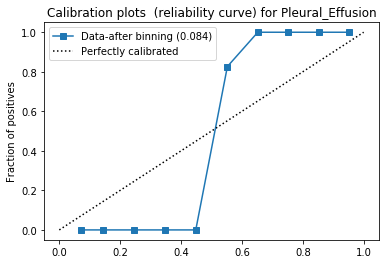

In [73]:
#Reliability Curve
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
true_label = np.asarray(df_bin_all[name+label]).astype(int)
predicted_prob = np.asarray(df_bin_all[name+'_prob']).astype(float)
fraction_of_positives, mean_predicted_value = calibration_curve(true_label, predicted_prob, n_bins=10)
clf_score = brier_score_loss(true_label, predicted_prob, pos_label=1)
plt.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % ('Data-after binning', clf_score))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.ylabel('Fraction of positives')
plt.ylim([-0.05, 1.05])
plt.title('Calibration plots  (reliability curve) for '+name)
plt.legend()
plt.show()

In [74]:
experiment_dir = os.path.join(main_dir,config['log_dir'], config['name'], 'explainer_MIMIC')
print(experiment_dir,name)
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

('/pghbio/dbmi/batmanlab/singla/Explanation_XRay/output/classifier/StanfordCheXpert_256_ICLR/explainer_MIMIC', 'Pleural_Effusion')


In [75]:
df_temp = df_bin_all[['names', 'bin']]
df_temp.to_csv(os.path.join(experiment_dir, 'list_attr_'+name+'.txt'), sep = ' ', index = None, header = None)
print(df_temp.shape)
one_line = str(df_temp.shape[0]) + '\n'
second_line = "0-0.09 0.1-0.19 0.2-0.29 0.3-0.39 0.4-0.49 0.5-0.59 0.6-0.69 0.7-0.79 0.8-0.89 0.9-0.99\n"
with open(os.path.join(experiment_dir, 'list_attr_'+name+'.txt'), 'r+') as fp:
    lines = fp.readlines()     # lines is list of line, each element '...\n'
    lines.insert(0, one_line)  # you can use any index if you know the line index
    lines.insert(1, second_line)
    fp.seek(0)                 # file pointer locates at the beginning to write the whole file again
    fp.writelines(lines) 
fp = open(os.path.join(experiment_dir, 'list_attr_'+name+'.txt'), 'rw')
print(fp.readline())
print(fp.readline())
print(fp.readline())
print(fp.readline())
print(fp.readline())
print(fp.readline())
df_bin_all.to_csv(os.path.join(experiment_dir, 'extra','Data_Output_Classifier_'+name+'.csv'), sep = ' ', index = None)

(40000, 2)
40000

0-0.09 0.1-0.19 0.2-0.29 0.3-0.39 0.4-0.49 0.5-0.59 0.6-0.69 0.7-0.79 0.8-0.89 0.9-0.99

/pghbio/dbmi/batmanlab/singla/Image_Text_Project/MIMICCX/Data/512/13777829/56360437/view3_lateral_HE.jpeg 9

/pghbio/dbmi/batmanlab/singla/Image_Text_Project/MIMICCX/Data/512/10559377/50009664/view2_lateral_HE.jpeg 9

/pghbio/dbmi/batmanlab/singla/Image_Text_Project/MIMICCX/Data/512/18550032/52260689/view2_lateral_HE.jpeg 9

/pghbio/dbmi/batmanlab/singla/Image_Text_Project/MIMICCX/Data/512/15263884/55078465/view2_lateral_HE.jpeg 9



In [114]:
np.random.randint(0, high=2, size=10)

array([0, 1, 1, 0, 1, 0, 1, 0, 0, 1])